# Text Mining With Python - Tutorial

## What we will cover today:
* Scraping text data from the Internet
* Cleaning and preprocessing the text data for analysis
* Making data visualizations with the cleaned/preprocessed text data that can give us interesting insights

## The First Jupyter Notebook Cell: Installing Word Cloud Library

Select the cell below by clicking anywhere in the cell. Click the "▶ Run" button above or press Shift+Enter.

The cell will run and install wordcloud library that we will use at the end of this tutorial. You should have all the other libraries we need already if you have downloaded Anaconda following the instruction on the GitHub page (where you downloaded this Jupyter Notebook).

In [1]:
import sys # for setting up the install location

!{sys.executable} -m pip install wordcloud

## Problem Statement

Our ultimate goal is to understand the differences between two major political parties in the US – the Republican party and the Democratic party. What are the things that each party values more? In what language do they express their positions? How have they changed over time?

## Collecting the Data

### Party Platforms
Party platforms are statements about where the parties stand on a variety of issues. In the US, new ones are written every four years, usually a few months before the upcoming presidential election. They are useful texts to understand the parties’ positions and how they are changing. ([2020 Democratic Party Platform](https://democrats.org/where-we-stand/party-platform/)) We may be able to discover something interesting by comparing the platforms between the parties and between different time periods.

### The American Presidency Project
[The American Presidency Project](https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms), maintained by UC Santa Barbara, has archived all the party platforms published in the US and made them publicly available for research purposes. There are 100 party platforms in total, and we will scrape all of them.

Let's try to scrape one party platform first. I wrote a function below that receives from us a URL to a party platform document and gives us the body text along with the title.

In [2]:
import requests
from bs4 import BeautifulSoup

def scrape_american_presidency_doc_content(url):
    '''
    Extract and returns text and title from a party platform document listed in 
    https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms.
    
    Parameters
        url: string, the URL of the webpage
    
    Returns     
        title: string, the title of the party platform
        text: string, the text of the party platform
    '''
    page_source = requests.get(url).text
    soup = BeautifulSoup(page_source, 'lxml')
    
    text = []
    for p in soup.find('div', class_="field-docs-content").find_all('p'):
        text.append(p.get_text(" "))
    
    # The title looks like either
    # "2016 Democratic Party Platform | The American Presidency Project" or
    # "Republican Party Platform of 1964 | The American Presidency Project".
    # First, I remove the name of the website after the "|" symbol.
    # (e.g., "2016 Democratic Party Platform | The American Presidency Project" becomes
    #        "2016 Democratic Party Platform")
    title = soup.find('title').text[:-34]
    
    # Second, I make the titles consistent by bringing the year to the beginning if it is at the end.
    # (e.g., "Republican Party Platform of 1964" becomes "1964 Republican Party Platform")
    #        "2016 Democratic Party Platform" stays as it is)
    if title[-1].isdigit():
        title = title[-4:]+' '+title[:-8]
    
    print('Processed:', title, url)
    
    return title, text

I'm testing the function by scraping the 2016 Democratic Party Platform below. It should give me the title first, and the body text following it.

In [3]:
scrape_american_presidency_doc_content('https://www.presidency.ucsb.edu/documents/2020-democratic-party-platform')

Processed: 2020 Democratic Party Platform https://www.presidency.ucsb.edu/documents/2020-democratic-party-platform


('2020 Democratic Party Platform',
 ['',
  'The Democratic National Committee wishes to acknowledge that we gather together to state our values on lands that have been stewarded through many centuries by the ancestors and descendants of Tribal Nations who have been here since time immemorial.',
  'We honor the communities native to this continent, and recognize that our country was built on Indigenous homelands.',
  'We pay our respects to the millions of Indigenous people throughout history who have protected our lands, waters, and animals.',
  'We respectfully acknowledge that we present this Platform at our 2020 Democratic National Convention on the lands of the Bad River Band of the Lake Superior Tribe of Chippewa Indians, the Forest County Potawatomi Community, the Ho-Chunk Nation, the Lac Courte Oreilles Band of Lake Superior Chippewa, the Lac du Flambeau Band of Lake Superior Chippewa, the Menominee Nation, the Oneida Nation of Wisconsin, the Red Cliff Band of Lake Superior Chip

Now let's try to scrape all the party platforms. To do so, we have to run this function for 100 times with 100 different URLs. Copying and pasting 100 URLs manually sound like a daunting task. Can't the computer do that for us as well? The function below scrapes all the hyperlinks to the party platform documents listed in one web page:

In [4]:
def scrape_american_presidency_doc_urls(url):
    '''
    Extract and returns hyperlinks to party platform documents from 
    https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms.
    
    Parameters
        url: string, the URL of the webpage
    
    Returns     
        hyperlinks: list, the list of hyperlinks scraped
    '''
    
    page_source = requests.get(url).text
    soup = BeautifulSoup(page_source, "lxml")

    hyperlinks = []
    for div in soup.find_all('div', class_="field-title"):
        for a in div.find_all('a'):
            hyperlinks.append(a['href'])
            
    print('Processed:', url)
            
    return hyperlinks

Let's test this function with the first page that lists ten most recent party platforms:

In [5]:
scrape_american_presidency_doc_urls('https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page=0')

Processed: https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page=0


['/documents/resolution-regarding-the-republican-party-platform',
 '/documents/2020-democratic-party-platform',
 '/documents/2016-democratic-party-platform',
 '/documents/2016-republican-party-platform',
 '/documents/2012-democratic-party-platform',
 '/documents/2012-republican-party-platform',
 '/documents/2008-republican-party-platform',
 '/documents/2008-democratic-party-platform',
 '/documents/2004-republican-party-platform',
 '/documents/2004-democratic-party-platform']

One page contains ten hyperlinks, and we have ten pages in total. The page number ranges from 0 to 9. With this information, we cane scrape all the hyperlinks we need:

In [6]:
url_head = 'https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page='
hyperlinks = []
for page_num in range(0, 10):
    hyperlinks += scrape_american_presidency_doc_urls(url_head + str(page_num))

Processed: https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page=0
Processed: https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page=1
Processed: https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page=2
Processed: https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page=3
Processed: https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page=4
Processed: https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page=5
Processed: https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page=6
Processed: https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms?page=7
Processed: https://www.presidency.ucsb.edu/documents/app-categor

How many URLs are in the list? If my code scraped all the hyperlinks, there should be 100 URLs.

In [7]:
len(hyperlinks)

100

What is the first URL in the list? It should be the link to the most recent party platform in this database - '/documents/resolution-regarding-the-republican-party-platform'.

In [8]:
hyperlinks[0]

'/documents/resolution-regarding-the-republican-party-platform'

What is the last URL in the list? It should be the oldest party platform in this database - '/documents/1840-democratic-party-platform'.

In [9]:
hyperlinks[99]

'/documents/1840-democratic-party-platform'

With the list of URLs we now have, we can finally scrape all the party platforms. It can take a couple of minutes, so I skip this cell in the tutorial video. If you want to run it yourself, remove the triple quotes at the beginning and at the end before running it.

After scraping all the data, I "pickled" the data for a later use. "Pickling" is basically exporting a Python object as a file; you can "unpickle" the file later to use it in Python again ([a more technical explanation](https://python.readthedocs.io/en/stable/library/pickle.html)).

In [ ]:
'''
import pickle
import time

data = {}
for url in hyperlinks:
    title, text = scrape_american_presidency_doc_content("https://www.presidency.ucsb.edu" + url)
    data[title] = text
    time.sleep(1)
    
# For storing the data for later use
with open('data_raw.p', 'wb') as file:
    pickle.dump(data, file)
'''

In [10]:
import pickle

with open('data_raw.p', 'rb') as file:
    data = pickle.load(file)

Did the scraping go well? Let's take a look at our full data. Our data is in the form of a "dictionary", in which "keys" are the titles and "values" are the body texts. We may call it a "corpus", which means a collection of texts.

The cell below shows us all the keys:

In [11]:
data.keys()

dict_keys(['Resolution Regarding the Republican Party Platform', '2020 Democratic Party Platform', '2016 Democratic Party Platform', '2016 Republican Party Platform', '2012 Democratic Party Platform', '2012 Republican Party Platform', '2008 Republican Party Platform', '2008 Democratic Party Platform', '2004 Republican Party Platform', '2004 Democratic Party Platform', '2000 Democratic Party Platform', '2000 Republican Party Platform', '1996 Democratic Party Platform', '1996 Republican Party Platform', '1992 Republican Party Platform', '1992 Democratic Party Platform', '1988 Republican Party Platform', '1988 Democratic Party Platform', '1984 Republican Party Platform', '1984 Democratic Party Platform', '1980 Democratic Party Platform', '1980 Republican Party Platform', '1976 Republican Party Platform', '1976 Democratic Party Platform', '1972 Republican Party Platform', '1972 Democratic Party Platform', '1972 Libertarian Party Platform', '1968 American Independent Party Platform', '1968 

By specifying a key, we can look up the value corresponding to it:

In [12]:
data['2020 Democratic Party Platform']

['',
 'The Democratic National Committee wishes to acknowledge that we gather together to state our values on lands that have been stewarded through many centuries by the ancestors and descendants of Tribal Nations who have been here since time immemorial.',
 'We honor the communities native to this continent, and recognize that our country was built on Indigenous homelands.',
 'We pay our respects to the millions of Indigenous people throughout history who have protected our lands, waters, and animals.',
 'We respectfully acknowledge that we present this Platform at our 2020 Democratic National Convention on the lands of the Bad River Band of the Lake Superior Tribe of Chippewa Indians, the Forest County Potawatomi Community, the Ho-Chunk Nation, the Lac Courte Oreilles Band of Lake Superior Chippewa, the Lac du Flambeau Band of Lake Superior Chippewa, the Menominee Nation, the Oneida Nation of Wisconsin, the Red Cliff Band of Lake Superior Chippewa, the St. Croix Chippewa Indians of 

Bonus: What if you want to save the data as files that can be opened outside of Python? You can save them as .txt file below:

In [13]:
!mkdir data

for title, text in data.items():
    with open('./data/'+title+'.txt', 'w', encoding='utf8') as file:
        for paragraph in text:
            file.write(paragraph + "\n")

A subdirectory or file data already exists.


## Preprocessing the Data: A Toy Example

Before we work on the actual data, let's take a look at a toy example because it's easier to see what's happening with a smaller dataset. I made a small dictionary below, which contains three haikus (very short Japanese poems) about spring. It has the same structure as our data we scraped above.

In [15]:
spring_haiku = {
    'Yosa Buson': 'The spring rain. / Talking and passing / The straw rain‐cape and umbrella.',
    'Murakami Kijo': 'The spring rain, / I definitely saw / The fay of stone.',
    'Mizuhara Shuoshi': 'The bush warbler. / The rain wouldn\'t let up. / The travel clothes.'
}

Based on this corpus, We want to make the table below. It is called "document-term matrix", a simple way to represent human-generated text in a form that a computer can read. 

This table stores the word (term) counts in each document. Each column label is a word, each row corresponds to a poem, and the numbers are the number of occurrences of the words in each poem.
<img src="images/dtm_example.png">

In [17]:
spring_haiku['Yosa Buson']

'The spring rain. / Talking and passing / The straw rain‐cape and umbrella.'

We first want to convert the texts into a list of words. There are many ways to do so, but let' try the tokenizer function included in NLTK (Natural Language Toolkit) library. (In a loose sense, a token is like a word, and to tokenize means to break down texts into tokens.)

In [16]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')

word_tokenize(spring_haiku['Yosa Buson'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\junelim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The',
 'spring',
 'rain',
 '.',
 '/',
 'Talking',
 'and',
 'passing',
 '/',
 'The',
 'straw',
 'rain‐cape',
 'and',
 'umbrella',
 '.']

We can notice that the slashes and periods are treated as individual tokens by the NLTK tokenizer. There is no fixed answer to how to treat punctuations and the decision depends on your goal and interests, but they often get removed when cleaning text data. Let's say we decided to remove punctuations.

In addition, let's try to normalize the cases by making all the letters to lower-case letters. Like punctuations, you could leave the letter cases as they are, but normalizing them is also a common text data cleaning step.

In [19]:
from string import punctuation

def non_punct_or_punct(char):
    '''
    Returns True if the character is NOT a punctuation; False otherwise. 
    '''
    if char in punctuation:
        return False
    else:
        return True

def clean_and_tokenize(text):
    '''
    Cleans and tokenizes the text and returns the tokens as a list.
    '''
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = filter(non_punct_or_punct, tokens)
    return list(tokens)

In [20]:
clean_and_tokenize(spring_haiku['Yosa Buson'])

['the',
 'spring',
 'rain',
 'talking',
 'and',
 'passing',
 'the',
 'straw',
 'rain‐cape',
 'and',
 'umbrella']

Now we are ready to create a document-term matrix. Scikit-learn's CountVectorizer makes it very easy to build one.

In addition to a corpus, I can pass a function to use as a tokenizer and a list of stop words. Stop words are extremely common words that usually do not have much value in data analysis (e.g., the, and, about). There are other parameters you could pass or change, and you can see them by pressing Shift+Tab with the cursor placed on the first line of the function.

To process my small haiku corpus, I passed the clean_and_tokenize function I wrote as a tokenizer for CountVectorizer to use. I did not pass any stop words this time because my corpus is so small.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def make_document_term_matrix(corpus, stop_words, tokenizer):
    '''
    Receives a corpus in a dictionary format and returns a document-term matrix made based on it.
    
    Parameters
        corpus: dictionary
        stop_words: list, list of stop words to remove
        tokenizer: function, function that tokenizes the corpus (if None, use the default tokenizer of scikit-learn)
    
    Returns     
        doc_term_mat: pandas dataframe, a document-term matrix
    '''
    vectorizer = CountVectorizer(stop_words=stop_words, tokenizer=tokenizer)
    vectors = vectorizer.fit_transform(corpus.values())
    doc_term_mat = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
    doc_term_mat.index = corpus.keys()
    return doc_term_mat

dt_matrix_haiku = make_document_term_matrix(spring_haiku, None, clean_and_tokenize)
dt_matrix_haiku

,and,bush,clothes,definitely,fay,i,let,n't,of,passing,...,spring,stone,straw,talking,the,travel,umbrella,up,warbler,would
Yosa Buson,2,0,0,0,0,0,0,0,0,1,...,1,0,1,1,2,0,1,0,0,0
Murakami Kijo,0,0,0,1,1,1,0,0,1,0,...,1,1,0,0,2,0,0,0,0,0
Mizuhara Shuoshi,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,3,1,0,1,1,1


A note about stop words: there are several standard stop words lists you could use, but like punctuations, lowercasing, and any other cleaning steps, the decision about which words are considered as stop words should be based on your data and goal. The next cell shows you the list of stop words included in scikit-learn.

In [22]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print(ENGLISH_STOP_WORDS)

frozenset({'whereby', 'will', 'to', 'yourselves', 'anyhow', 'back', 'been', 'top', 'sometime', 'they', 'somehow', 'alone', 'throughout', 'serious', 'for', 'thereafter', 'once', 'herein', 'interest', 'first', 'along', 'still', 'mine', 'everything', 'do', 'be', 'front', 'three', 'noone', 'have', 'such', 'whole', 'further', 'one', 'whither', 'onto', 'therein', 'each', 'her', 'somewhere', 'above', 'both', 'hence', 'again', 'rather', 'yet', 'whereas', 'are', 'i', 'themselves', 'seeming', 'himself', 'has', 'but', 'until', 'beyond', 'hereby', 'there', 'meanwhile', 'and', 'afterwards', 'over', 'everywhere', 'several', 'on', 'sincere', 'into', 'latter', 'may', 'from', 'take', 'them', 'ours', 'already', 'hereafter', 'should', 'up', 'we', 'elsewhere', 'de', 'hereupon', 're', 'thru', 'anything', 'here', 'ltd', 'least', 'why', 'his', 'detail', 'found', 'describe', 'too', 'down', 'together', 'fifteen', 'very', 'thereupon', 'were', 'show', 'though', 'wherein', 'whereupon', 'an', 'when', 'than', 'now'

The next cell shows you the list of stop words included in NLTK.

In [23]:
from nltk.corpus import stopwords
nltk.download('stopwords')

print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\junelim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing the Data: Party Platforms

Time to come back to the party platform corpus. Before proceeding to create a document-term matrix, let's take a look at our data again. The next cell shows the title of the first document in it:

In [24]:
next(iter(data.keys()))

'Resolution Regarding the Republican Party Platform'

The body text of the first document looks like:

In [25]:
next(iter(data.values()))

['WHEREAS, The Republican National Committee (RNC) has significantly scaled back the size and scope of the 2020 Republican National Convention in Charlotte due to strict restrictions on gatherings and meetings, and out of concern for the safety of convention attendees and our hosts;',
 'WHEREAS, The RNC has unanimously voted to forego the Convention Committee on Platform, in appreciation of the fact that it did not want a small contingent of delegates formulating a new platform without the breadth of perspectives within the ever-growing Republican movement;',
 'WHEREAS, All platforms are snapshots of the historical contexts in which they are born, and parties abide by their policy priorities, rather than their political rhetoric;',
 "WHEREAS, The RNC, had the Platform Committee been able to convene in 2020, would have undoubtedly unanimously agreed to reassert the Party's strong support for President Donald Trump and his Administration;",
 'WHEREAS, The media has outrageously misrepres

I have a list of strings as a value of my dictionary. Why? When I scraped the data, the text was split into paragraphs and I put them into a list. I'd like to merge them into one big string because it's easier to deal with. Let's do it and see the merged data:

In [26]:
for title, text in data.items():
    data[title] = ' '.join(text)

In [27]:
next(iter(data.values()))

"WHEREAS, The Republican National Committee (RNC) has significantly scaled back the size and scope of the 2020 Republican National Convention in Charlotte due to strict restrictions on gatherings and meetings, and out of concern for the safety of convention attendees and our hosts; WHEREAS, The RNC has unanimously voted to forego the Convention Committee on Platform, in appreciation of the fact that it did not want a small contingent of delegates formulating a new platform without the breadth of perspectives within the ever-growing Republican movement; WHEREAS, All platforms are snapshots of the historical contexts in which they are born, and parties abide by their policy priorities, rather than their political rhetoric; WHEREAS, The RNC, had the Platform Committee been able to convene in 2020, would have undoubtedly unanimously agreed to reassert the Party's strong support for President Donald Trump and his Administration; WHEREAS, The media has outrageously misrepresented the implica

Now our corpus is ready to be preprocessed into a document-term matrix. This time I tell the CountVectorizer to use scikit-learn's standard stop-word list and tokenizer.

In [28]:
dt_mat = make_document_term_matrix(data, 'english', None)
dt_mat

,00,000,008,028,072,076,094,10,100,1000,...,ziemann,zika,zimbabwe,zimbabwean,zimmer,zionism,zip,zone,zones,zoning
Resolution Regarding the Republican Party Platform,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020 Democratic Party Platform,0,21,0,0,0,0,0,9,7,0,...,0,0,0,0,0,0,4,0,1,0
2016 Democratic Party Platform,0,2,0,0,0,0,0,4,2,0,...,0,2,0,0,0,0,3,0,1,0
2016 Republican Party Platform,0,8,0,0,0,0,0,1,4,0,...,0,1,0,0,0,0,1,2,2,3
2012 Democratic Party Platform,0,16,0,0,0,0,0,6,5,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848 Whig Party Platform,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1848 Democratic Party Platform,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1844 Democratic Party Platform,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1844 Whig Party Platform,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Draw Word Clouds to Examine the Most Frequent Words

We converted a bunch of texts into a bunch of numbers that a computer can read. Now it’s time for some data analysis!

### Word Clouds

We can do so many things with this document-term matrix, but since this is a short tutorial, I'll show you how to do a simple exploratory data analysis by visualizing them as word clouds. Word clouds are an intuitive way to visulize texts. By looking at word clouds, we could decide which aspect of the data we want to dig deeper into and develop our research question further.

### Comparison Between the Parties

How does the language of the Democratic Party differ from that of the Republican Party? Let's represent the party platforms published in 2012 as word clouds and compare them.

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def draw_word_clouds_dem_rep(data, year):
    '''
    Draws a pair of word clouds, one for Democratic Party Platform and one for Republican Party Platform.
    Saves it as a .png file.
    
    Parameters
        data: a document-term matrix
        year: int, the year of publication
    '''
    wc = WordCloud(max_words=100, background_color='white', colormap='Dark2', max_font_size=150, random_state=1)
    plt.rcParams['figure.figsize'] = [20, 10]
    num = 0
    for title in [' Democratic Party Platform', ' Republican Party Platform']:
        data_dict = dict(zip(data.columns, data.loc[str(year)+title]))
        wc.generate_from_frequencies(data_dict)
        num += 1
        
        plt.subplot(1, 2, num)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(str(year)+title, fontsize=20)
        
    # Save the plot as a file; instead of '.png', other formats such as '.pdf' or '.jpg' can be used
    plt.savefig("party_platforms_"+str(year)+'.png')
    # Display the plot
    plt.show()

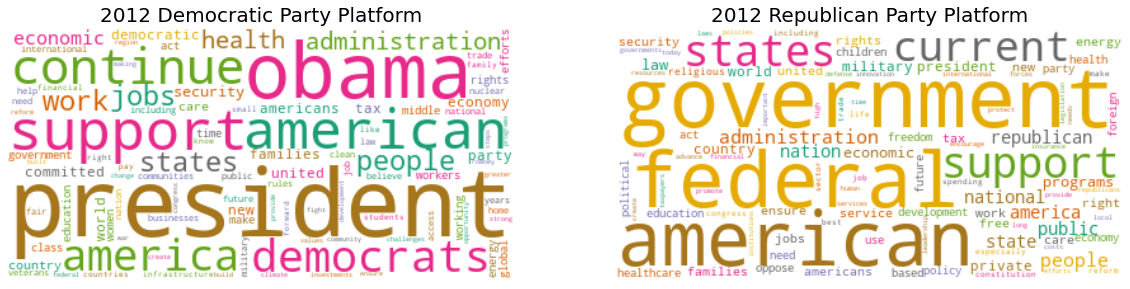

In [30]:
draw_word_clouds_dem_rep(dt_mat, 2012)

### Word Counts vs. tf-idf

There are many overlapping words between the two parties such as "american" and "states". It’s not surprising that there are common words that usually appear in party platforms. If they are not emphasized this much, it might have been easier for us to see the more interesting words that actually distinguish the two parties.

We cau solve this issue by using tf–idf (term frequency–inverse document frequency) instead of word counts. Tf-idf is a measurement that reflects how important a word is to a document in a corpus.

<br><center><b>tf (term frequency)</b>: raw term count (word count) / the total number of terms (words) in the document<br> 
    <b>idf (inverse document frequency)</b>: log (the total number of documents / the number of documents in which the term appears)<br>
    <b>tf-idf</b>: <b>tf</b> * <b>idf</b></center><br>

[More details about tf-idf (Wikipedia)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Term_frequency%E2%80%93Inverse_document_frequency)

We could make a document-term matrix that contains tf-idf scores rather than word counts with scikit-learn's TfidfVectorizer.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

def make_tfidf_document_term_matrix(corpus, stop_words, tokenizer):
    vectorizer = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenizer)
    vectors = vectorizer.fit_transform(corpus.values())
    data_tfidf_mat = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
    data_tfidf_mat.index = corpus.keys()
    return data_tfidf_mat

tfidf_dt_mat = make_tfidf_document_term_matrix(data, 'english', None)
tfidf_dt_mat.head(3) # show only the first three rows

,00,000,008,028,072,076,094,10,100,1000,...,ziemann,zika,zimbabwe,zimbabwean,zimmer,zionism,zip,zone,zones,zoning
Resolution Regarding the Republican Party Platform,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2020 Democratic Party Platform,0.0,0.017930,0.0,0.0,0.0,0.0,0.0,0.008546,0.00757,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.008413,0.0,0.001492,0.0
2016 Democratic Party Platform,0.0,0.003285,0.0,0.0,0.0,0.0,0.0,0.007306,0.00416,0.0,...,0.0,0.009123,0.0,0.0,0.0,0.0,0.012136,0.0,0.002871,0.0


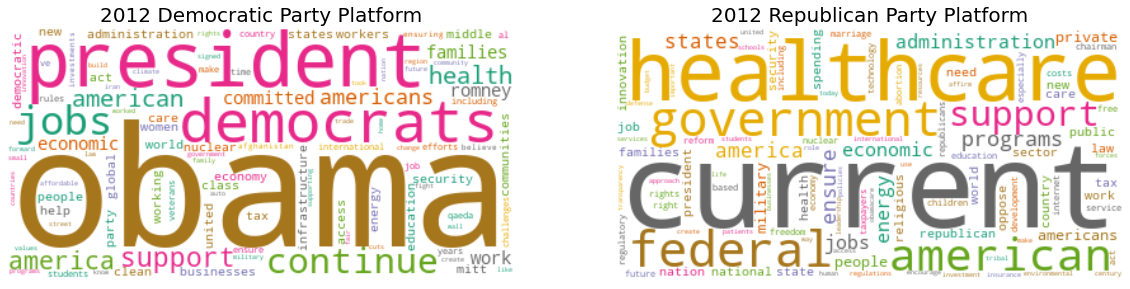

In [33]:
draw_word_clouds_dem_rep(tfidf_dt_mat, 2012)

### Comparison Between the Time Periods

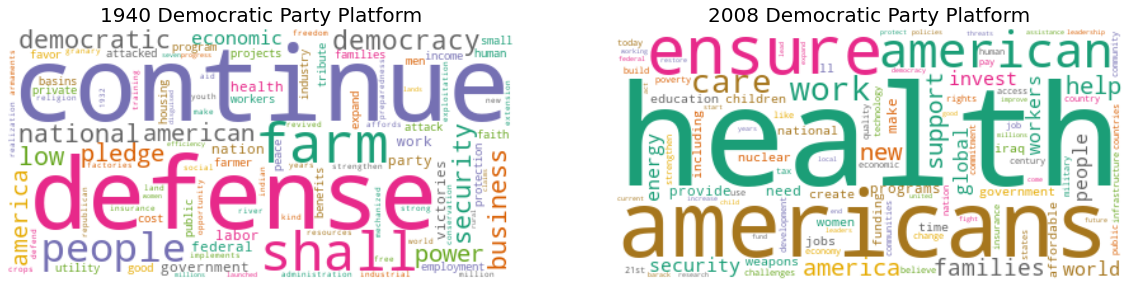

In [34]:
def draw_word_clouds_older_newer(data, party, year1, year2):
    '''
    Draws a pair of word clouds, one for Democratic Party Platform and one for Republican Party Platform.
    Saves it as a .png file.
    
    Parameters
        data: a document-term matrix
        party: string, either dem or rep
        year1: int, year of publication
        year2: int, year of publication to compare against year 1
    '''
    wc = WordCloud(max_words=100, background_color='white', colormap='Dark2', max_font_size=150, random_state=1)
    plt.rcParams['figure.figsize'] = [20, 10]
    num = 0
    
    title = ''
    if party == 'dem':
        title = ' Democratic Party Platform'
    else:
        title = ' Republican Party Platform'
    
    for year in [year1, year2]:
        data_dict = dict(zip(data.columns, data.loc[str(year)+title]))
        wc.generate_from_frequencies(data_dict)
        num += 1
        
        plt.subplot(1, 2, num)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(str(year)+title, fontsize=20)
        
    # Save the plot as a file; instead of '.png', other formats such as '.pdf' or '.jpg' can be used
    plt.savefig("party_platforms_"+str(year)+'.png')
    # Display the plot
    plt.show()
    
draw_word_clouds_older_newer(tfidf_dt_mat, 'dem', 1940, 2008)

Before we finish, let's store the document-term matrices we have made for a later use. If we have another tutorial, we could load them in a new Jupyter Notebook and do more advanced data analysis with various machine learning methods!

In [35]:
# For storing the data for later use
with open('dtm.p', 'wb') as file:
    pickle.dump(dt_mat, file)

with open('tfidf_dtm.p', 'wb') as file:
    pickle.dump(tfidf_dt_mat, file)